# HOML Chapter 3, Exercise 3 

- Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic/overview/description).

Quickly reading thru the description, we find the data we need and the goal.

**Goal**: It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, you must predict a 0 or 1 value for the variable.

When looking at the survived column below, we notice that it is a binary feature. Thus this is a classification problem.

**Performace Measure**: With this dataset, we aim to be as accurate and precise as possible. The F1 score or the recall/precision scores should work nicely.

While I would like to automate the downloading of the Data, Kaggle's HTML does not allow us to follow a download path. The user must go to the Kaggle website for the data. 

In [1]:
#Goes down the path and loads the data as a pandas dataframe. 
from zipfile import ZipFile
import os
import pandas as pd
#I already made a titanic folder in a dat setsfolder. 
#The below code finds it saves the path without manually doign it
DATA_PATH = os.path.join("datasets", "titanic")
def load_data(path=DATA_PATH, dataset ="train"):
    #We want th training data
    csv_path = os.path.join(path, dataset+".csv")
    return pd.read_csv(csv_path)

In [2]:
train_data = load_data()
test_data = load_data(dataset= "test")
X = train_data.copy()
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We need to define what the features are, from Kaggle:

![Features](./datasets/titanic/Features.png)


**Variable Notes**

**pclass**: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower


**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

    **Sibling** = brother, sister, stepbrother, stepsister

    **Spouse** = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

    **Parent** = mother, father

    **Child** = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

The above readMe showed that many of the features might be ordinal or categorical. We can examine the head for this or we can plot the data and view histograms.  

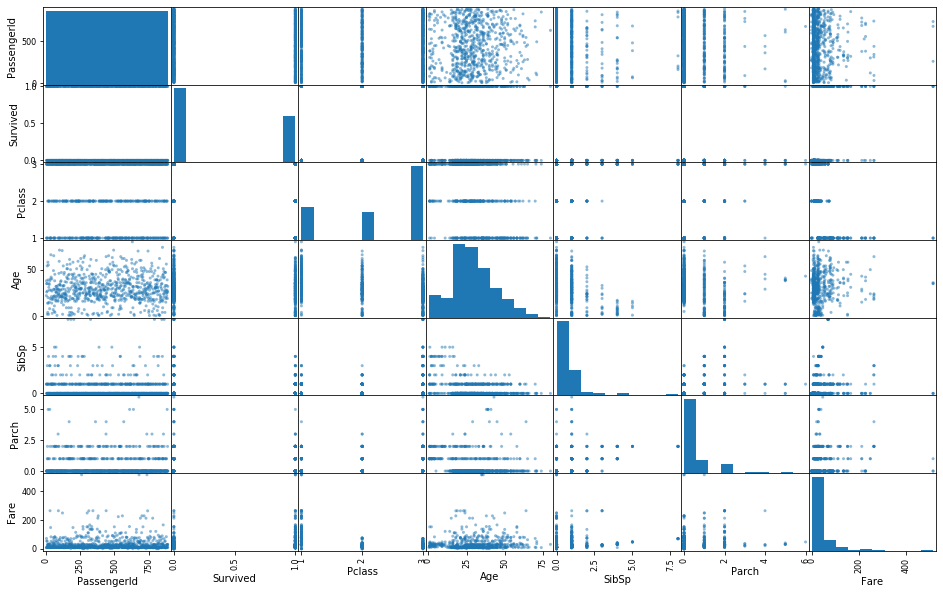

In [3]:
from pandas.plotting import scatter_matrix
X.select_dtypes('number')
scatter_matrix(X.select_dtypes('number'), figsize=(16, 10));

The matrix presents that most of the numerical categories are ordinal, the only continuous categories are Age and Fare. 

To further explore the data we can check our assumptions. I have assumptions about social-economic importance. I believe that gender and wealth played a role in survival rates.

We can use Pandas' built-in grouby method to expedite this process.

In [4]:
#Use count the the number of people
#Divide by length to the the percent of people
X[["Sex", "Survived",'Fare']].groupby(["Sex", "Survived"]).count() / len(X)

Fare
Sex    Survived          
female 0         0.090909
       1         0.261504
male   0         0.525253
       1         0.122334

Grouping on Sex and Survived tells us that out of the survivors, most were women.

This time we can use the mean method to view the average fair for the genders

In [5]:
X[["Sex", "Survived",'Fare']].groupby(["Sex", "Survived"]).mean()

Fare
Sex    Survived           
female 0         23.024385
       1         51.938573
male   0         21.960993
       1         40.821484

More so, the average Fare for the surviving women was higher than their not-so-lucky counterparts. For men the tread carries on, the higher the fare the better the chance of surviving. 

Clearly, gender and wealth played a part in surviving, hopefully, our exploration is correct and feature selection does not deviate. 


# Dealing with missing values 

With our assumption checked, we will explore the dataset for missing values.

In [6]:
X.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The isnull method converts non-missing data into zeros, and missing values into 1. Thus, when we sum, we see the total number of missing values per column.

In [7]:
X['Cabin'].isnull().sum() / len(X)

0.7710437710437711

While there are methods to handle missing values, when the number of missing values for a feature is higher than 40 percent of the total instances, those methods tend to behave poorly. When this happens it is better to remove that feature from existence. 

In [8]:
X.drop('Cabin', inplace = True, axis= 1)

In [9]:
X['Age'].isnull().sum() / len(X)

0.19865319865319866

When the sum of the missing values for a particular feature is less than 40, we can use the imputer methods. The imputer methods require that the passed data is only numerical.

In [10]:
#We need to work on only the numerical data
#We save the numerical columns as list, so we can save the imputed data later
numerics = list(X.select_dtypes('number').columns)

In [11]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(X.select_dtypes('number'))
X[numerics] = imputer.transform(X.select_dtypes('number'))

Lastly, Embarked and Sex are categorical columns that have not yet been transformed into an ordinal category. Since Embarked has missing values we cannot use Sklearn's ordinal Encoder. We could explore all the data and predict features, that is a lot of work and there is an easier method. When the number of instances is really low we can simply drop the data.

In [12]:
X.drop( X.loc[X["Embarked"].isnull()].index,inplace = True, axis = 0 )

In [13]:
X.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Now that we have processed the data for missing values, we can enhance the data set by changing categorical values to ordinal values.

In [14]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X[['Embarked','Sex']] = ordinal_encoder.fit_transform(X[['Embarked','Sex']])

In [15]:
ordinal_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object), array(['female', 'male'], dtype=object)]

When using the Ordinal Encoder, each value in the array is encoded by its position. Thus, female is 0 and male is 1. 

With that out of the way we have a few more things to deal with, we have categorical data in Name and Ticket. These features cannot use sklearn's ordinal encoder because most of the instances are unique. It is text data and to process it we must use methods in NLP.

Rather than work on it, we will simply drop the features.

In [16]:
X.drop(['Name', 'Ticket'], inplace= True, axis = 1)

In [17]:
X.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0.0,3.0,1.0,22.0,1.0,0.0,7.2500,2.0
1,2.0,1.0,1.0,0.0,38.0,1.0,0.0,71.2833,0.0
2,3.0,1.0,3.0,0.0,26.0,0.0,0.0,7.9250,2.0
3,4.0,1.0,1.0,0.0,35.0,1.0,0.0,53.1000,2.0
4,5.0,0.0,3.0,1.0,35.0,0.0,0.0,8.0500,2.0


We are almost done with feature exploration, there are a few things we have not stated. Pclass is very much like Fare, but Fare is the precise value that would lead to a PClass. We will exclude PClass from modeling for that reason.


Now that we have arrived at the features we will use for modeling, we can make a pipeline to quickly transform the data as we did above. 

In [18]:
#Taken from
# https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [20]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [21]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        #Rather than drop the categorical data that is missing, the above list comprehension looks for the most 
        #Frequent thing in every column, It then uses this information to fill in missing values
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [22]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])


In [23]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [24]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [25]:
y_train = train_data["Survived"]

In [26]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [27]:
from sklearn.model_selection import cross_val_score
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

From the HOML solutions, it wants us to have an accuracy of over 80%. One way we can accomplish this is thru a different model.

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

Choosing a different model worked best on our data. More so we can view the targeted performace measures.

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)

# Precision and recall

While the model tells us our predictions are mainly right, we can view some classification statistics.

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[458,  91],
       [ 96, 246]], dtype=int64)

The first row of this matrix considers the death case(0) (the negative class): 458 of them were correctly classified as non-survival (they are called true negatives), while the remaining 191 were wrongly classified as survived(1) (false positives).

The second row considers the surviving case (the positive class): 96 were wrongly classified as deaths (false negatives), while the remaining 246 were correctly classified as survivals (true positives). A perfect classifier would have only true positives and true negatives.

With these in mind, we can sklearn to calculate the precision/recall. 

In [31]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred) 

0.7299703264094956

In [32]:
recall_score(y_train, y_train_pred)  # == 4096 / (4096 + 1325)

0.7192982456140351


The precision score shows that 73% of our Survived predictions are correct. The recall score tells us that we are 72% correct when predicting those who did not survive. 

Overall this is an accurate model and the cross-validation score places us in the 10% of Kagglers attempting this. 

# Testing Data 


An important part in modeling is verifying the predictions on unseen data.

In [49]:
y_test = load_data(dataset= "gender_submission")
y_test.drop('PassengerId', inplace = True, axis =1)

In [50]:
X_test = preprocess_pipeline.fit_transform(test_data)

In [51]:
forest_clf.fit(X_train, y_train)
y_test_pred=  forest_clf.predict(X_test)

In [52]:
precision_score(y_test, y_test_pred) 

0.7361963190184049

In [53]:
recall_score(y_train, y_train_pred)  # == 4096 / (4096 + 1325)

0.7192982456140351

The above score did slightly better than the precision/recall scores on our testing set. 

# Summary 

In this project we explored the Titanic data set from Kaggle, exploration showed that women had a higher chance of surviving. After a lot of feature exploration and transformation, we modeled the data with various classifiers. The cross-validation score showed that our model was amongst the best in Kaggle's submissions. More so, the precision/recall scores showed that we are both. Since absolute precision/recall was a goal, we did well. While we would like both of them to be 100% we cannot do so without impacting the score of the other, due to the precision/recall trade-off.